In [1]:
# All Includes
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.decomposition import PCA
import xgboost as xgb

from skimage.transform import resize

from sklearn.metrics import confusion_matrix

import pywt

import tensorflow as tf
print(f"FensorFlow version: {tf.__version__}")
#import keras (high level API) wiht tensorflow as backend
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

FensorFlow version: 2.0.0


In [2]:
def load_y_data(y_path):
    y = np.loadtxt(y_path, dtype=np.int32).reshape(-1,1)
    # change labels range from 1-6 t 0-5, this enables a sparse_categorical_crossentropy loss function
    return y - 1

def load_X_data(X_path):
    X_signal_paths = [X_path + file for file in os.listdir(X_path)]
    X_signals = [np.loadtxt(path, dtype=np.float32) for path in X_signal_paths]
    return np.transpose(np.array(X_signals), (1, 2, 0))

In [3]:
PATH = '.../UCI HAR Dataset/'
LABEL_NAMES = ["Walking", "Walking upstairs", "Walking downstairs", "Sitting", "Standing", "Laying"]

# load X data
X_train = load_X_data(PATH + 'train/Inertial Signals/')
X_test = load_X_data(PATH + 'test/Inertial Signals/')
# load y label
y_train = load_y_data(PATH + 'train/y_train.txt')
y_test = load_y_data(PATH + 'test/y_test.txt')

print("useful information:")
print(f"shapes (n_samples, n_steps, n_signals) of X_train: {X_train.shape} and X_test: {X_test.shape}")
X_all = np.concatenate([X_train, X_test])
print(f"all X's have following mean: {format(X_all.mean(), '.2f')} and standard derivation: {format(X_all.std(), '.2f')} ")

useful information:
shapes (n_samples, n_steps, n_signals) of X_train: (7352, 128, 9) and X_test: (2947, 128, 9)
all X's have a mean of: 0.10 and a standard derivation of: 0.40 


In [67]:
import _pickle as cPickle
path = 'C:/Users/Sebastian/Documents/GitHub/191102_Time_series_classf/data/Image_data/'

X_train_cwt = cPickle.load( open(path + "X_train_cwt_64_pixel.pkl", "rb" ) )
print(f"X_train shape: {X_train_cwt.shape}")

X_test_cwt = cPickle.load( open(path + "X_test_cwt_64_pixel.pkl", "rb" ) )
print(f"y_train shape: {X_test_cwt.shape}")

X_train shape: (7352, 64, 64, 9)
y_train shape: (2947, 64, 64, 9)


In [4]:
def split_indices_per_label(y):
    indicies_per_label = [[] for x in range(0,6)]
    # loop over the six labels
    for i in range(6): 
        indicies_per_label[i] = np.where(y == i)[0]
    return indicies_per_label

# list of list of sample indicies per activity
train_labels_indicies = split_indices_per_label(y_train)

In [ ]:
def plot_cwt_coeffs_per_label(X, label_indicies, label_names, signal, sample, scales, wavelet):
    
    fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12,5))
    
    for ax, indices, name in zip(axs.flat, label_indicies, label_names):
        coeffs, freqs = pywt.cwt(X[indices[sample],:, signal], scales, wavelet = wavelet)
        ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
        ax.set_title(name)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('Scale')
        ax.set_xlabel('Time')
    plt.tight_layout()
    
#signal indicies: 0 = body acc x, 1 = body acc y, 2 = body acc z, 3 = body gyro x, 4 = body gyro y, 5 = body gyro z, 6 = total acc x, 7 = total acc y, 8 = total acc z
signal = 3 # signal index
sample = 1 # sample index of each label indicies list
scales = np.arange(1, 65) # range of scales
wavelet = 'morl' # mother wavelet

plot_cwt_coeffs_per_label(X_train, train_labels_indicies, LABEL_NAMES, signal, sample, scales, wavelet)

In [ ]:
#signal indicies: 0 = body acc x, 1 = body acc y, 2 = body acc z, 3 = body gyro x, 4 = body gyro y, 5 = body gyro z, 6 = total acc x, 7 = total acc y, 8 = total acc z
signal = 8 # signal index
sample = 1 # sample index of each label indicies list
scales = np.arange(1, 65) # range of scales
wavelet = 'morl' # mother wavelet

plot_cwt_coeffs_per_label(X_train, train_labels_indicies, LABEL_NAMES, signal, sample, scales, wavelet)

In [53]:
def create_cwt_images(X, n_scales, rescale_size, wavelet_name = "morl"):
    n_samples = X.shape[0] 
    n_signals = X.shape[2] 
    
    # range of scales from 1 to n_scales
    scales = np.arange(1, n_scales + 1) 
    
    # pre allocate array
    X_cwt = np.ndarray(shape=(n_samples, rescale_size, rescale_size, n_signals), dtype = 'float32')
    
    for sample in range(n_samples):
        if sample % 1000 == 0:
            print(sample)
        for signal in range(n_signals):
            serie = X[sample, :, signal]
            # continuous wavelet transform 
            coeffs, freqs = pywt.cwt(serie, scales, wavelet_name)
            # resize the 2D cwt coeffs
            rescale_coeffs = resize(coeffs, (rescale_size, rescale_size), mode = 'constant')
            X_cwt[sample,:,:,signal] = rescale_coeffs
            
    return X_cwt

In [54]:
# amount of pixels in X and Y 
rescale_size = 64
# determine the max scale size
n_scales = 64

X_train_cwt = create_cwt_images(X_train, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: {X_train_cwt.shape}")
X_test_cwt = create_cwt_images(X_test, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: {X_test_cwt.shape}")

0
1000
2000
3000
4000
5000
6000
7000
0
1000
2000
shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: (7352, 64, 64, 9) and X_test_cwt: (2947, 64, 64, 9)


In [6]:
def build_cnn_model(activation, input_shape):
    model = Sequential()
    
    # 2 Convolution layer with Max polling
    model.add(Conv2D(32, 5, activation = activation, padding = 'same', input_shape = input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 5, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D())  
    model.add(Flatten())
    
    # 3 Full connected layer
    model.add(Dense(128, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(54, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(6, activation = 'softmax')) # 6 classes
    
    # summarize the model
    print(model.summary())
    return model

In [7]:
def compile_and_fit_model(model, X_train, y_train, X_test, y_test, batch_size, n_epochs):

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])
    
    # define callbacks
    callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_sparse_categorical_accuracy', save_best_only=True)]
    
    # fit the model
    history = model.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))
    
    return model, history

In [8]:
# shape of the input images
input_shape = (X_train_cwt.shape[1], X_train_cwt.shape[2], X_train_cwt.shape[3])

# create cnn model
cnn_model = build_cnn_model("relu", input_shape)
# train cnn model
#trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_train_cwt, y_train, X_test_cwt, y_test, 368, 10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        7232      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dense_1 (Dense)              (None, 54)                6

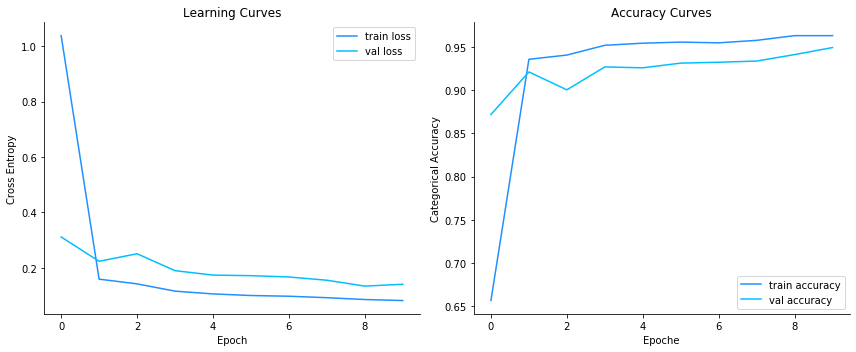

In [9]:
def plot_model_performance_curves(history):
    fig = plt.figure(figsize=(12,5))

    # plot Cross Entropy loss
    ax = fig.add_subplot(121)
    ax.plot(history.history['loss'], color='dodgerblue', label='train loss')
    ax.plot(history.history['val_loss'], color = 'deepskyblue', label='val loss')
    ax.legend()
    ax.set_title('Learning Curves')
    ax.set_ylabel('Cross Entropy')
    ax.set_xlabel('Epoch')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # plot classification accuracy
    ax = fig.add_subplot(122)
    ax.plot(history.history['sparse_categorical_accuracy'], color='dodgerblue', label='train accuracy')
    ax.plot(history.history['val_sparse_categorical_accuracy'], color = 'deepskyblue', label='val accuracy')
    ax.legend()
    ax.set_title('Accuracy Curves')
    ax.set_ylabel('Categorical Accuracy')
    ax.set_xlabel('Epoche')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.show()


plot_model_performance_curves(cnn_history)

Accuracy: 94.91%


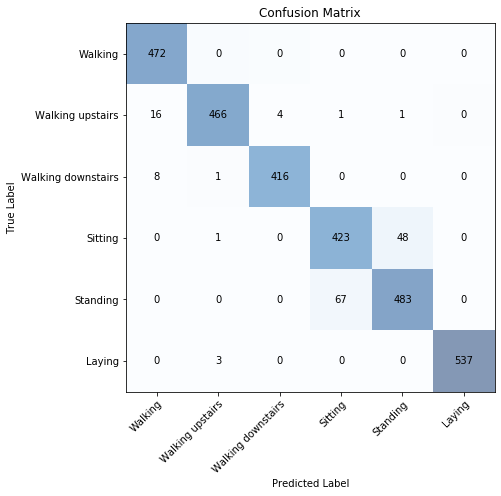

In [68]:
def create_confusion_matrix(y_pred, y_test):    
    #calculate the confusion matrix
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(confmat, cmap=plt.cm.Blues, alpha=0.5)

    n_labels = len(LABEL_NAMES)
    ax.set_xticks(np.arange(n_labels))
    ax.set_yticks(np.arange(n_labels))
    ax.set_xticklabels(LABEL_NAMES)
    ax.set_yticklabels(LABEL_NAMES)

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # loop over data dimensions and create text annotations.
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=i, y=j, s=confmat[i, j], va='center', ha='center')
    
    # avoid that the first and last row cut in half
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    ax.set_title("Confusion Matrix")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

# make predictions for test data
y_pred = trained_cnn_model.predict_classes(X_test_cwt)
# determine the total accuracy 
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

create_confusion_matrix(y_pred, y_test)

In [71]:
def pca_of_cwt_coeffs(X, n_scales, wavelet_name="morl"):
    # apply PCA for just a single component to get the most significant coefficient per scale
    pca = PCA(n_components = 1)
    # create range of scales
    scales = np.arange(1, n_scales + 1)
    
    X_pca = np.array([])  
    for signal in range(X.shape[2]):
        pca_comps = np.empty((0, n_scales),dtype='float32')
        for sample in range(X.shape[0]):
            coeffs, freqs = pywt.cwt(X[sample, :, signal], scales, wavelet_name)    
            pca_comps = np.vstack([pca_comps, pca.fit_transform(coeffs).flatten()]) 
                    
        if signal == 0:
            X_pca = pca_comps
        else:
            X_pca = np.concatenate((X_pca, pca_comps), axis=1)
            
    return X_pca

In [72]:
# define the scale size
n_scales = 64

X_train_pca = pca_of_cwt_coeffs(X_train, n_scales)
print(f"shapes (n_samples, n_comps) of X_train_pca: {X_train_pca.shape}")
X_test_pca = pca_of_cwt_coeffs(X_test, n_scales)
print(f"shapes (n_samples, n_comps) of X_test_pca: {X_test_pca.shape}")

shapes (n_samples, n_comps) of X_train_pca: (7352, 576)
shapes (n_samples, n_comps) of X_test_pca: (2947, 576)


In [49]:
def build_and_fit_xgb_model(X_train, y_train, X_test, y_test, n_depth, subsample, n_estimators):
    xgb_model = xgb.XGBClassifier(max_depth=n_depth, 
                              objective='multi:softmax', # error evaluation for multiclass training
                              num_class=6, 
                              subsample=subsample, # randomly selected fraction of training samples that will be used to train each tree.
                              n_estimators=n_estimators) 
    eval_set = [(X_train, y_train), (X_test, y_test)]
    history = xgb_model.fit(X_train, y_train, eval_metric=["merror"], eval_set=eval_set,verbose=True)
    return xgb_model, history

In [57]:
#4 and 0.5
trained_xgb_model, xgb_history = build_and_fit_xgb_model(X_train_pca, y_train, X_test_pca, y_test, 4, 0.5, 200)

[0]	validation_0-merror:0.093716	validation_1-merror:0.162878
[1]	validation_0-merror:0.082699	validation_1-merror:0.153376
[2]	validation_0-merror:0.079978	validation_1-merror:0.141161
[3]	validation_0-merror:0.074538	validation_1-merror:0.137767
[4]	validation_0-merror:0.072361	validation_1-merror:0.131999
[5]	validation_0-merror:0.072905	validation_1-merror:0.131659
[6]	validation_0-merror:0.069233	validation_1-merror:0.128266
[7]	validation_0-merror:0.067601	validation_1-merror:0.123515
[8]	validation_0-merror:0.067057	validation_1-merror:0.123855
[9]	validation_0-merror:0.065968	validation_1-merror:0.122837
[10]	validation_0-merror:0.066104	validation_1-merror:0.124873
[11]	validation_0-merror:0.066376	validation_1-merror:0.124194
[12]	validation_0-merror:0.064744	validation_1-merror:0.122158
[13]	validation_0-merror:0.063928	validation_1-merror:0.117747
[14]	validation_0-merror:0.062976	validation_1-merror:0.117747
[15]	validation_0-merror:0.062568	validation_1-merror:0.118765
[1

[131]	validation_0-merror:0.002312	validation_1-merror:0.079063
[132]	validation_0-merror:0.00204	validation_1-merror:0.078724
[133]	validation_0-merror:0.001768	validation_1-merror:0.078385
[134]	validation_0-merror:0.001632	validation_1-merror:0.078385
[135]	validation_0-merror:0.001632	validation_1-merror:0.078385
[136]	validation_0-merror:0.001632	validation_1-merror:0.078045
[137]	validation_0-merror:0.001496	validation_1-merror:0.077706
[138]	validation_0-merror:0.000952	validation_1-merror:0.077706
[139]	validation_0-merror:0.001224	validation_1-merror:0.076688
[140]	validation_0-merror:0.001224	validation_1-merror:0.077367
[141]	validation_0-merror:0.001224	validation_1-merror:0.077706
[142]	validation_0-merror:0.00136	validation_1-merror:0.077367
[143]	validation_0-merror:0.001088	validation_1-merror:0.078045
[144]	validation_0-merror:0.000952	validation_1-merror:0.078045
[145]	validation_0-merror:0.000952	validation_1-merror:0.078385
[146]	validation_0-merror:0.000816	validat

Accuracy: 92.67%


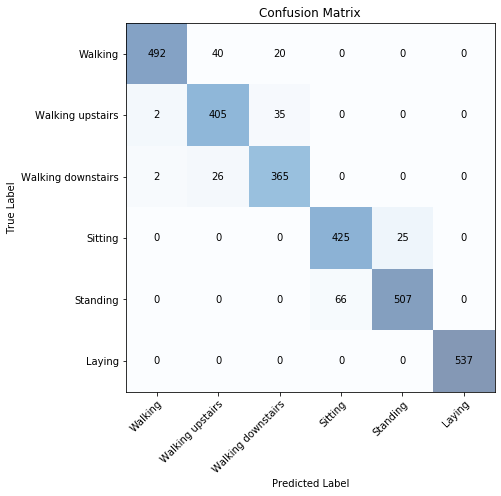

In [63]:
# make predictions for test data
y_pred = trained_xgb_model.predict(X_test_pca)
# determine the total accuracy 
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

create_confusion_matrix(y_pred, y_test)